In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import pandas as pd
#import librosa
import logging
import os
from scipy.io import wavfile

#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# Configure the logging settings
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def audio_to_mel_spectrogram(audio_file_path, max_length=4*22500, sr=22500, n_mels=256):
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=sr)
    
    if len(y) > max_length:
        # If the audio is longer than the maximum length, cut it
        y = y[:max_length]
    elif len(y) < max_length:
        # If the audio is shorter, pad it with zeros
        pad_length = max_length - len(y)
        y = np.pad(y, (0, pad_length), mode='constant')
    
    # Calculate the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram


In [3]:
# for audio_file in audio_files[:3]:
#     print(audio_to_mel_spectrogram(audio_file).shape)
#     plt.imshow(audio_to_mel_spectrogram(audio_file))


NameError: name 'audio_files' is not defined

In [4]:
# Generator function for lazy loading of audio data
def audio_data_generator(audio_files):
    for audio_file in audio_files:
        yield audio_to_mel_spectrogram(audio_file)

# Load a list of audio files
audio_files_df = pd.read_csv('data_files_summary.csv')
audio_files = audio_files_df['full_path'].to_list()

In [5]:
%%time
# Create a generator to load and preprocess audio data on-the-fly
data_generator = audio_data_generator(audio_files)
data_iterator = iter(data_generator)  # Convert the generator to an iterator

# To train an autoencoder, you need target data, which is the same as the input data
# So, use the same data for both input and target
X_train = np.array(list(data_iterator))
X_train.shape

C:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


CPU times: total: 28.8 s
Wall time: 30.3 s


(6300, 128, 176)

In [6]:
X_train = X_train.reshape(6300, 128, 176, 1)

In [7]:
X_train_scaled = ((X_train + 80)/80)
X_train_scaled.min(), X_train_scaled.max()

(0.0, 1.0)

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Normalization, Reshape, Dense, Flatten, Cropping2D
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (128, 176, 1)  # You can adjust the input shape based on your data

# Define the encoder
input_layer = Input(shape=input_shape)
x = input_layer

x = Conv2D(128, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(256)(x)
encoded = x

x = Dense(8*11*8)(x)
x = Reshape((8, 11, 8))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Cropping2D(cropping=((3, 0), (0, 0)))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)

# Compile the autoencoder
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)

autoencoder.compile(optimizer='adam', loss=mse)
# Print the model summary
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 176, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 176, 128)     1280      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 88, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 88, 32)        36896     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 44, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 22, 8)         2312

In [72]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=2, verbose=1, restore_best_weights=True)
# Step 3: Train the autoencoder using audio data
logging.info('Training the autoencoder...')
autoencoder.fit(X_train_scaled, X_train_scaled, batch_size=128, epochs=50, callbacks=[early_stopping])
logging.info('Training complete.')

2023-10-20 15:34:43,959 - root - INFO - Training the autoencoder...


Epoch 1/50
50/50 [==============================] - 561s 11s/step - loss: 51763.2188
Epoch 2/50
50/50 [==============================] - 536s 11s/step - loss: 50005.5273
Epoch 3/50
50/50 [==============================] - 528s 11s/step - loss: 48522.1133
Epoch 4/50
50/50 [==============================] - 527s 11s/step - loss: 47009.6719
Epoch 5/50
50/50 [==============================] - 526s 11s/step - loss: 46335.0820
Epoch 6/50
50/50 [==============================] - 526s 11s/step - loss: 45622.6406
Epoch 7/50
50/50 [==============================] - 527s 11s/step - loss: 44886.4414
Epoch 8/50
50/50 [==============================] - 523s 10s/step - loss: 44532.0469
Epoch 9/50
50/50 [==============================] - 523s 10s/step - loss: 44425.6523
Epoch 10/50
50/50 [==============================] - 524s 10s/step - loss: 43881.6914
Epoch 11/50
50/50 [==============================] - 523s 10s/step - loss: 44084.6797
Epoch 12/50
50/50 [==============================] - 523s 10s/s

KeyboardInterrupt: 

In [73]:
autoencoder.save('autoencoder_model')

INFO:tensorflow:Assets written to: autoencoder_model\assets


2023-10-20 20:41:15,097 - tensorflow - INFO - Assets written to: autoencoder_model\assets


In [96]:
import soundfile as sf  # Soundfile library for saving the WAV file
def mel_spectrogram_to_audio(mel_spectrogram, max_length=4*22500, sr=22500):
    # Inverse of power_to_db
    mel_spectrogram = librosa.db_to_power(mel_spectrogram)
    # Inverse of melspectrogram
    y = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr)
    
    return y

# Example usage
spectrogram = audio_to_mel_spectrogram("converted.wav", sr=44100).reshape((1, 128, 176, 1))
spectrogram = (spectrogram+80)/80
out_spectre = autoencoder.predict(spectrogram)
out_spectre = (out_spectre*80)-80
out_spectre = out_spectre.reshape((128, 176))
reconstructed_audio = mel_spectrogram_to_audio(out_spectre, 44100) * 1e2
sf.write("reconstructed_audio.wav", np.ravel(reconstructed_audio), 44100)  # Adjust the sample rate as needed


1/1 [==============================] - 0s 37ms/step


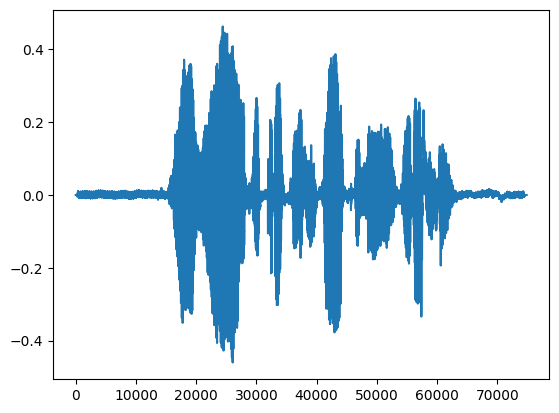

In [91]:
y, sr = librosa.load('converted.wav', sr=22500, duration=112500)
plt.plot(y)

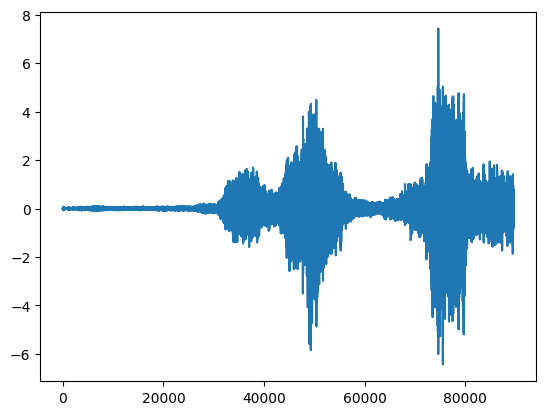

In [92]:
plt.plot(reconstructed_audio)

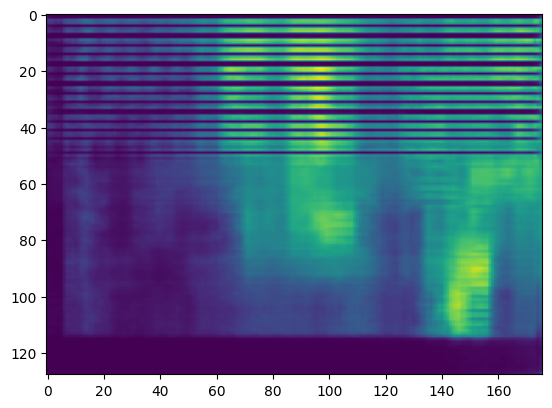

In [93]:
plt.imshow(out_spectre)

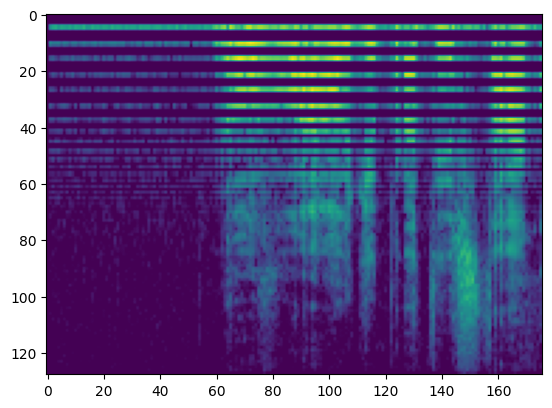

In [94]:
plt.imshow(spectrogram[0])

1/1 [==============================] - 0s 37ms/step


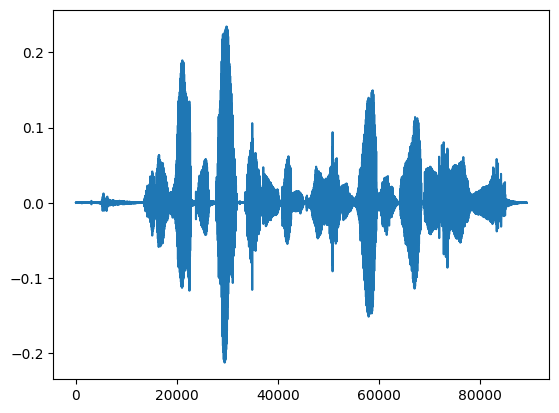

In [79]:
import soundfile as sf  # Soundfile library for saving the WAV file
def mel_spectrogram_to_audio(mel_spectrogram, max_length=4*22500, sr=22500):
    # Inverse of power_to_db
    mel_spectrogram = librosa.db_to_power(mel_spectrogram)
    # Inverse of melspectrogram
    y = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr)
    
    return y

# Example usage
spectrogram = audio_to_mel_spectrogram(audio_files[0]).reshape((1, 128, 176, 1))
spectrogram = (spectrogram+80)/80
out_spectre = autoencoder.predict(spectrogram)
out_spectre = (out_spectre*80)-80
out_spectre = out_spectre.reshape((128, 176))
reconstructed_audio = mel_spectrogram_to_audio(out_spectre) #* 1e3
y, sr = librosa.load(audio_files[0], sr=22500, duration=112500)
plt.plot(y)

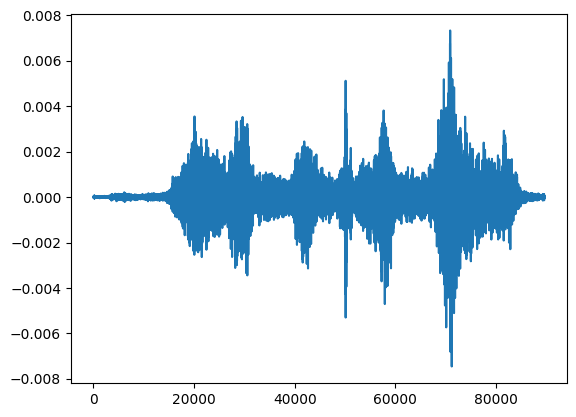

In [80]:
plt.plot(reconstructed_audio)

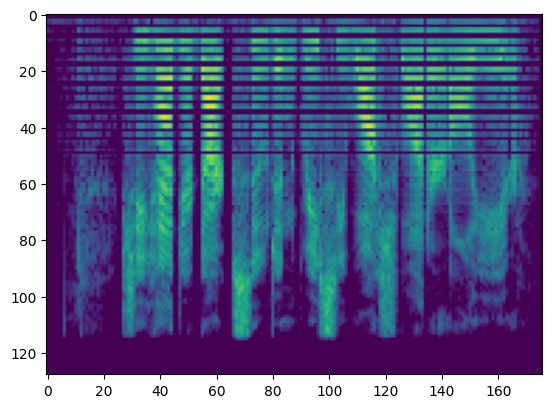

In [81]:
plt.imshow(spectrogram.reshape((128, 176)))

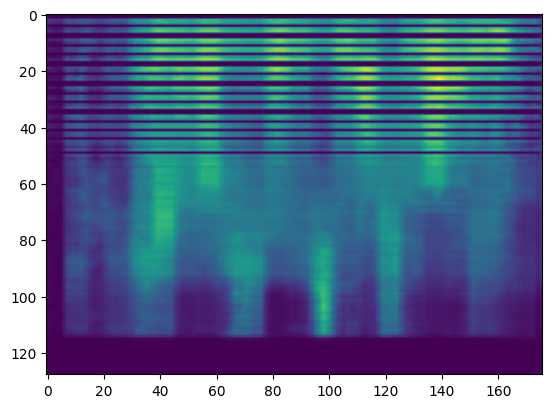

In [82]:
plt.imshow(out_spectre)

In [83]:
a = spectrogram.reshape((128, 176))
b = out_spectre
(((a+80)/80-(b+80)/80)**2).mean(),\
(((a+80)/80-(b+80)/80)**2).sum()

(0.64676404, 14570.301)